In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
import os

In [ ]:
path = '../data/raw/archive'
#after this we'll load a portion of the data 50% should be enough

data = (pd.read_csv(os.path.join(path, 'accepted_2007_to_2018Q4.csv'))
        .sample(frac=1, random_state=1)
        .drop(labels=['id','desc','title'], axis=1)
        )
#we save it as a parquet file for faster future sessions loading
os.makedirs('../data/clean', exist_ok=True)
data.to_parquet('../data/clean/data_chunck.parquet')

**First step :** some data exploration

In [ ]:
data = pd.read_parquet('../data/clean/data_chunck.parquet').sample(frac=0.5, random_state=0)
data.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,...,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,1.130329e+06,1.130329e+06,1.130329e+06,1.130329e+06,1.130329e+06,1.130327e+06,1.129453e+06,1.130316e+06,1.130329e+06,...,5567.0,5567.000000,5567.0,5567.000000,4419.000000,5567.000000,5567.000000,17188.000000,17188.000000,17188.000000
mean,NaN,1.505392e+04,1.504873e+04,1.503096e+04,1.309273e+01,4.459697e+02,7.796788e+04,1.883210e+01,3.064745e-01,6.986019e+02,...,3.0,154.326677,3.0,13.754985,448.132057,11606.486578,196.187244,4995.950615,47.793343,13.185129
std,NaN,9.200472e+03,9.198707e+03,9.202521e+03,4.836388e+00,2.675203e+02,9.340873e+04,1.432857e+01,8.690206e-01,3.299986e+01,...,0.0,128.651842,0.0,9.697526,370.562907,7622.128024,202.237777,3664.122578,7.743815,8.173729
min,NaN,5.000000e+02,5.000000e+02,0.000000e+00,5.310000e+00,4.930000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.100000e+02,...,3.0,1.610000,3.0,0.000000,11.280000,193.980000,0.010000,44.210000,0.200000,0.000000
25%,NaN,8.000000e+03,8.000000e+03,8.000000e+03,9.490000e+00,2.515800e+02,4.600000e+04,1.189000e+01,0.000000e+00,6.750000e+02,...,3.0,59.090000,3.0,5.000000,173.295000,5603.180000,44.435000,2208.880000,45.000000,6.000000
50%,NaN,1.292500e+04,1.290000e+04,1.280000e+04,1.262000e+01,3.782000e+02,6.500000e+04,1.785000e+01,0.000000e+00,6.900000e+02,...,3.0,118.580000,3.0,15.000000,348.150000,9949.480000,134.120000,4154.935000,45.000000,14.000000
75%,NaN,2.000000e+04,2.000000e+04,2.000000e+04,1.599000e+01,5.934900e+02,9.300000e+04,2.450000e+01,0.000000e+00,7.150000e+02,...,3.0,213.270000,3.0,22.000000,612.885000,16210.065000,286.830000,6793.097500,50.000000,18.000000
max,NaN,4.000000e+04,4.000000e+04,4.000000e+04,3.099000e+01,1.719830e+03,6.100000e+07,9.990000e+02,5.800000e+01,8.450000e+02,...,3.0,943.940000,3.0,37.000000,2680.890000,40306.410000,1407.860000,27000.000000,521.350000,181.000000


In [ ]:
print(data['loan_status'].unique())

['Current' 'Fully Paid' 'Charged Off' 'In Grace Period'
 'Late (31-120 days)'
 'Does not meet the credit policy. Status:Charged Off' 'Late (16-30 days)'
 'Does not meet the credit policy. Status:Fully Paid' 'Default' None]


As the loan status is not binary and some situations are worse than other, instead of classifying good vs bad, we will do a mapping of the risk score

In [2]:
def data_mapping(data):
    mapping = {
        'Fully Paid': 0,
        'Current': 0,
        'In Grace Period': 1,
        'Late (16-30 days)': 2,
        'Late (31-120 days)': 3,
        'Does not meet the credit policy. Status:Fully Paid': 0,
        'Does not meet the credit policy. Status:Charged Off': 4,
        'Charged Off': 4,
        'Default': 5
    }

    data['risk_score']= data['loan_status'].map(mapping)
    data = (data.dropna(subset=['risk_score'])
            .drop(labels='loan_status', axis=1)
            )
    return data

Now what we wanna look for is maybe a correlation in the data, let's check with annual income

C:\Users\PC\AppData\Local\Temp\ipykernel_18324\871108651.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(by='income_bin')


Text(0.5, 0, '')

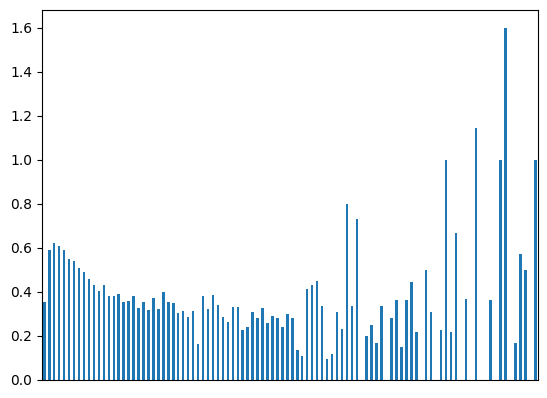

In [ ]:
sample_data = data[['risk_score','annual_inc']].copy()
sample_data = sample_data[sample_data['annual_inc'] < 1_000_000]

sample_data['income_bin'] = pd.cut(sample_data['annual_inc'], bins=100)
sample_data = (sample_data.drop(labels='annual_inc', axis=1)
               .groupby(by='income_bin')
               .mean()
               )
sample_data.plot(kind='bar', legend=False, xticks=[])
plt.xlabel("")

We see no clear relation between risk and income, maybe due to the fact that people with more money tend to borrow more
To make sure the data is good,we should also look at the distribution of income 
We apply a log transform and we filter outliers (>1M a year and <10k)

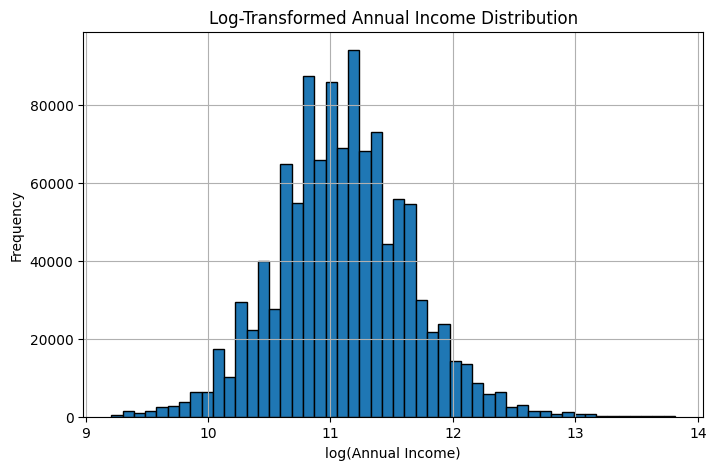

In [ ]:
sample_data = data.loc[(data['annual_inc'] < 1_000_000) & (data['annual_inc'] > 10_000), 'annual_inc']
log_income = np.log(sample_data)  
plt.figure(figsize=(8, 5))
plt.hist(log_income, bins=50, edgecolor='black')
plt.title('Log-Transformed Annual Income Distribution')
plt.xlabel('log(Annual Income)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The distribution looks good, we may look for correlation in other variables, but some cleaning before

In [3]:
def correlation_matrix(data):
    cat_columns = [col for col in data.columns if data[col].dtype=='object']
    num_columns = [col for col in set(data.columns) if col not in set(cat_columns)]

    numeric_data = data[num_columns].copy()
    corr_matrix = numeric_data.corr()
    return (cat_columns,num_columns, corr_matrix)


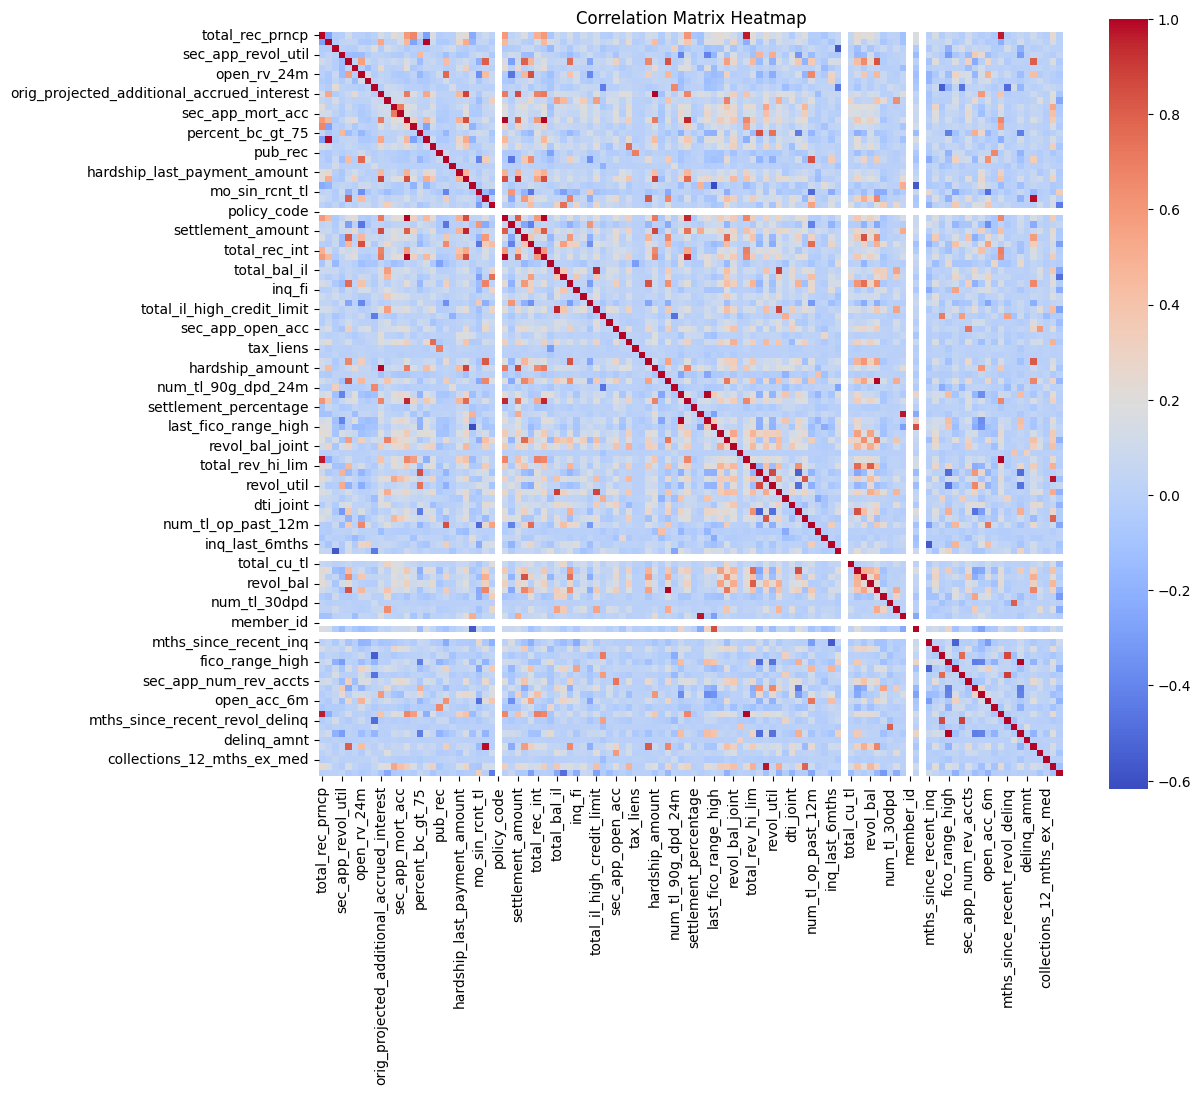

In [ ]:

_,_,corr_matrix=correlation_matrix(data)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

We're looking for columns to drop, because this data is too high dimentional, so to not affect future model performance, we'll look for every 2 columns that have a correlation $c$ where $|c|> .9$

In [4]:
def filter_matrix(corr_matrix):
    coef_dict = {}
    #we'll get correlated columns in a dict 
    for i,col1 in enumerate(corr_matrix.columns):
        for j,col2 in enumerate(corr_matrix.columns):
            if j<i: #we do this to go throught only the triangular half so we filter the diagonal and avoid dupes (a,b)(b,a) 
                correlation = corr_matrix.loc[col1,col2]
                if np.abs(correlation) >= 0.9:
                    coef_dict[(col1,col2)] = correlation
    return coef_dict

In [ ]:
_,num_columns,_ = correlation_matrix(data)
numeric_data = data[num_columns].copy()
coef_dict= filter_matrix(corr_matrix)
temp_set = set()
for a,b in coef_dict.keys():
    if a not in temp_set:
        temp_set.add(a)
        numeric_data = numeric_data.drop(labels=a, axis=1)

print(temp_set)

{'num_rev_tl_bal_gt_0', 'total_pymnt', 'sec_app_fico_range_high', 'total_il_high_credit_limit', 'loan_amnt', 'settlement_amount', 'total_pymnt_inv', 'fico_range_low', 'tot_hi_cred_lim', 'installment', 'open_acc', 'funded_amnt', 'hardship_amount', 'recoveries', 'out_prncp'}


In [ ]:
new_corr_mat = numeric_data.corr()
new_dict = filter_matrix(new_corr_mat)
print(new_dict)
numeric_data.shape

{}


(1130329, 99)

Perfect ! we rules out the correlated data and are left with 99 numerical columns 

In [ ]:
#we now look for missing values
row_nan_counts = numeric_data.isna().sum(axis=1)
print(row_nan_counts.value_counts().sort_index())

3      2
4     12
5     27
6     32
7     21
      ..
74    33
75     3
76     5
83    11
84     2
Name: count, Length: 69, dtype: int64


We also check for columns that may have a lot of missing values, more than 30% missing values is not reasonable to keep

In [ ]:
cols_over_30pct_nan = numeric_data.columns[numeric_data.isna().mean() > 0.3].tolist()
print(cols_over_30pct_nan)
#we directly drop them, too shallow for any realistic use
numeric_data = numeric_data.drop(labels=cols_over_30pct_nan, axis=1)
numeric_data.shape

['sec_app_revol_util', 'settlement_term', 'open_rv_24m', 'sec_app_inq_last_6mths', 'orig_projected_additional_accrued_interest', 'sec_app_mort_acc', 'open_rv_12m', 'hardship_last_payment_amount', 'hardship_payoff_balance_amount', 'open_il_12m', 'mths_since_last_record', 'total_bal_il', 'open_il_24m', 'inq_fi', 'mths_since_last_major_derog', 'sec_app_open_acc', 'annual_inc_joint', 'sec_app_collections_12_mths_ex_med', 'sec_app_fico_range_low', 'settlement_percentage', 'max_bal_bc', 'revol_bal_joint', 'sec_app_mths_since_last_major_derog', 'dti_joint', 'sec_app_chargeoff_within_12_mths', 'hardship_dpd', 'deferral_term', 'total_cu_tl', 'il_util', 'open_act_il', 'member_id', 'hardship_length', 'mths_since_last_delinq', 'inq_last_12m', 'mths_since_recent_bc_dlq', 'sec_app_num_rev_accts', 'all_util', 'open_acc_6m', 'mths_since_recent_revol_delinq', 'sec_app_open_act_il', 'mths_since_rcnt_il']


(1130329, 58)

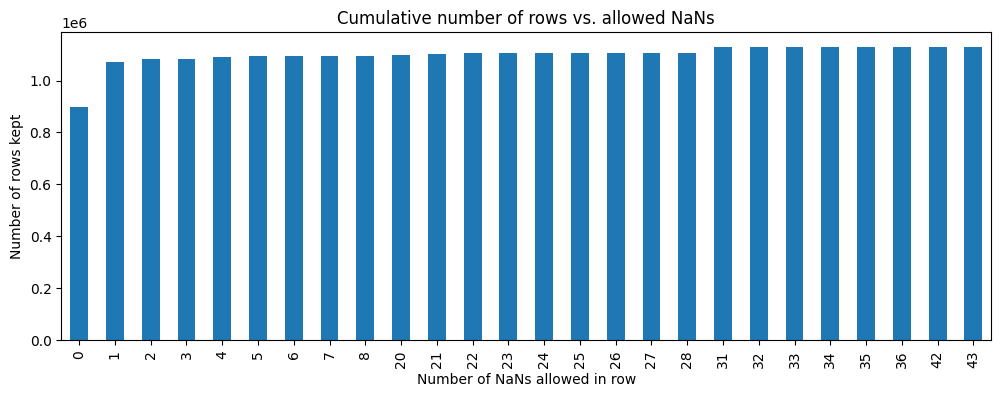

In [ ]:
#we do a plot to decide from where to limit the number of nans in the rows
row_nan_counts = numeric_data.isna().sum(axis=1)
row_nan_counts.value_counts().sort_index().cumsum().plot(kind='bar', figsize=(12,4))
plt.title('Cumulative number of rows vs. allowed NaNs')
plt.xlabel('Number of NaNs allowed in row')
plt.ylabel('Number of rows kept')
plt.show()

**Good News** we can drop all missing value columns and be left with 900k rows to use

In [5]:
#we condense all our precedent code in a single function for easier future use
def num_data_prep(data):

    num_cols = [col for col in data.columns if data[col].dtype != 'object']
    mat = data[num_cols].corr()

    coef_dict= filter_matrix(mat)
    temp_set = set()
    for a,b in coef_dict.keys():
        if a not in temp_set:
            temp_set.add(a)
            data = data.drop(labels=a, axis=1)
    
    cols_over_30pct_nan = data.columns[data.isna().mean() > 0.3].tolist()
    data = data.drop(labels=cols_over_30pct_nan, axis=1)
    data = data.dropna(axis=0)

    return data

We now have to deal with the categorical variables

In [ ]:
cat,_,_ = correlation_matrix(data)
categoric_data = data[cat].copy()
categoric_data.head()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,...,hardship_status,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_loan_status,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date
1010636,36 months,B,B1,None,None,OWN,Not Verified,Mar-2016,Current,n,...,None,None,None,None,None,Cash,N,None,None,None
2083227,36 months,C,C3,Mechanic Supervisor,< 1 year,MORTGAGE,Not Verified,Nov-2017,Fully Paid,n,...,None,None,None,None,None,Cash,N,None,None,None
1975179,36 months,D,D3,Supervisor,5 years,RENT,Verified,Aug-2016,Fully Paid,n,...,None,None,None,None,None,Cash,N,None,None,None
858623,36 months,A,A3,Tour Guide,5 years,RENT,Not Verified,Jul-2018,Current,n,...,None,None,None,None,None,DirectPay,N,None,None,None
779019,36 months,D,D1,Assistant Manager,3 years,RENT,Verified,Sep-2018,Current,n,...,None,None,None,None,None,Cash,N,None,None,None


In [ ]:
print(categoric_data.columns.to_list())

['term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'pymnt_plan', 'url', 'purpose', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'application_type', 'verification_status_joint', 'sec_app_earliest_cr_line', 'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_loan_status', 'disbursement_method', 'debt_settlement_flag', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date']


We'll do some cleaning on features already encoded in others, with no useful information or with very high cardinality 

In [6]:
def drop_useless(data):
    print(f'number of cols to drop: {len(cols_to_drop)}')
    print(f'data shape before dropping: {data.shape}')

    data = data.drop(labels=cols_to_drop, axis=1, errors='ignore')
    data = data.dropna()
    
    print(f'{len(cols_to_drop)} columns dropped successfuly')
    print(f'data shape after dropping: {data.shape}')

    return data

In [ ]:
data = drop_useless(data)
#we get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: data[col].nunique(), cat))
d = dict(zip(cat, object_nunique))

sorted(d.items(), key=lambda x: x[1])

[('term', 2),
 ('debt_settlement_flag', 2),
 ('initial_list_status', 2),
 ('verification_status', 3),
 ('home_ownership', 6),
 ('loan_status', 9),
 ('emp_length', 11),
 ('purpose', 14),
 ('addr_state', 51),
 ('earliest_cr_line', 734)]

In [7]:
#we encode employement lenght and map it to integer values
def emp_lenght_map(categoric_data):
    map_emp_lenght = {
        None: -1,'< 1 year': 0,'1 year':1,'2 years':2,'3 years':3,
        '4 years':4,'5 years':5,'6 years':6,'7 years':7,'8 years':8,
        '9 years':9,'10+ years':10
    }
    categoric_data['length'] = categoric_data['emp_length'].map(map_emp_lenght)
    categoric_data = categoric_data.drop(labels='emp_length',axis=1)
    print('employement lenght encoded successfuly')
    return categoric_data

In [8]:
#we convert to datetime and compute how long it was
def earliest_to_date(categoric_data):

    categoric_data = categoric_data.copy()
    categoric_data['earliest_cr_line'] = pd.to_datetime(
        categoric_data['earliest_cr_line'], format='%b-%Y', errors='coerce'
    )
    print(f"Rows with invalid 'earliest_cr_line': {categoric_data['earliest_cr_line'].isna().sum()}")

    #took this part out because we'll need all the columns transformers to output the same number of rows, we'll drop them later
    #categoric_data = categoric_data[categoric_data['earliest_cr_line'].notna()] 
    #print(f"Rows with invalid 'earliest_cr_line' after droping: {categoric_data['earliest_cr_line'].isna().sum()}")

    today = pd.to_datetime('today')
    categoric_data['credit_history_length'] = (today - categoric_data['earliest_cr_line']).dt.days

    categoric_data = pd.DataFrame(categoric_data).drop(columns=['earliest_cr_line'], axis=1)

    print(f"Remaining rows: {len(categoric_data)}, earliest cr data encoded successfuly")
    return categoric_data

In [9]:
#frequency encoding the last two with high cardinality
def freq_encoding(categoric_data):
    for col in ['purpose', 'addr_state']:
        freq_encoding = categoric_data[col].value_counts(normalize=True)
        categoric_data[col + '_freq'] = categoric_data[col].map(freq_encoding)

    categoric_data.drop(columns=['purpose', 'addr_state'], inplace=True)
    print(f'frequency data encoded successfuly')
    return categoric_data

We are finally ready to build a full preprocessing Pipeline, the categorical columns left all are of cardinality <10 we can one hot encode them without exploding the data size

In [10]:
ohe_cols = ['term','debt_settlement_flag','initial_list_status','verification_status','home_ownership']
freq_cols = ['purpose','addr_state']
cols_to_drop=['sub_grade','issue_d','url','emp_title','settlement_date','verification_status_joint',
                'sec_app_earliest_cr_line','zip_code','pymnt_plan','application_type','disbursement_method',
                'debt_settlement_flag_date','settlement_status','hardship_start_date','hardship_end_date',
                'payment_plan_start_date','next_pymnt_d','issue_d','grade','hardship_type','last_pymnt_d',
                'last_credit_pull_d','hardship_loan_status','hardship_flag','hardship_status','hardship_reason',
    ]


In [11]:
preprocessor = ColumnTransformer([

    ('scale', RobustScaler(), make_column_selector(dtype_include='number')),
    ('frequency_cols', FunctionTransformer(freq_encoding), freq_cols),
    ('employement_lenght', FunctionTransformer(emp_lenght_map), ['emp_length']),
    ('account_age', FunctionTransformer(earliest_to_date), ['earliest_cr_line']),
    ('cat_left', OneHotEncoder(), ohe_cols)
    
], verbose=True)

pipe = Pipeline([
    
    ('num_auto_clean', FunctionTransformer(num_data_prep)),
    ('drop', FunctionTransformer(drop_useless)),
    ('features', preprocessor),
    ('model', DummyRegressor())
], verbose=True)

In [13]:
df = pd.read_parquet('../data/raw/data_chunck.parquet').sample(frac=1, random_state=19)

df = data_mapping(df)
df_y = df['risk_score']
df = df.drop(labels='risk_score',axis=1)

X_train, X_val, y_train, y_val = train_test_split(df,df_y, test_size=0.8, random_state=19)

In [165]:
X_trans = pipe[:-1].transform(X_train)

number of cols to drop: 26
data shape before dropping: (167178, 78)
26 columns dropped successfuly
data shape after dropping: (167178, 66)
frequency data encoded successfuly
employement lenght encoded successfuly
Rows with invalid 'earliest_cr_line': 0
Remaining rows: 167178, earliest cr data encoded successfuly


In [164]:
pd.DataFrame(X_trans).describe()

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,75
count,167178.000000,167178.000000,167178.000000,167178.000000,167178.000000,167178.000000,167178.000000,167178.000000,167178.000000,167178.000000,...,167178.000000,167178.000000,167178.000000,167178.000000,167178.000000,167178.000000,167178.000000,167178.000000,167178.000000,167178.000000
mean,0.147923,0.083326,0.268988,0.071157,0.316872,0.193785,0.608746,0.170252,0.204788,0.354139,...,0.699793,0.324863,0.420444,0.254693,0.000371,0.514398,0.000012,0.000024,0.103823,0.381372
std,0.768043,0.774978,1.749972,0.952020,0.879321,0.810434,0.864320,0.814643,0.619440,1.494038,...,0.458349,0.468325,0.493632,0.435690,0.019254,0.499794,0.003459,0.004891,0.305032,0.485725
min,-1.050000,-1.177033,-1.498478,-1.477697,0.000000,-0.750000,0.000000,-1.428571,0.000000,-0.808309,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.466667,-0.468900,-0.413043,-0.468775,0.000000,-0.375000,0.000000,-0.428571,0.000000,-0.376634,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.533333,0.531100,0.586957,0.531225,0.000000,0.625000,1.000000,0.571429,0.000000,0.623366,...,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,2.200000,2.918660,183.282609,79.544201,35.000000,3.875000,6.000000,11.428571,86.000000,62.006116,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
